In [125]:
import os
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchsummary import summary

from artificial_dataloader import *
sys.path.append('../')
from pre_process import *

torch.cuda.empty_cache()

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [126]:
def getData(csv_path, train_path, batch_size=7, num_workers=0):
    ''' get images from the folder (assets/images) and return a DataLoader object '''
    
    dataset = ArtificialLidarDatasetCNN(csv_path, train_path)

    train_size, val_size = int(0.8*len(dataset)), np.ceil(0.2*len(dataset)).astype('int')
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=num_workers)
    val_data  = DataLoader(val_dataset, batch_size=batch_size, shuffle=True,num_workers=num_workers)

    # get one image shape from the train_data
    for i, data in enumerate(train_data):
        print(f'images shape: {data["image"].shape}')
        print(f'label length: {len(data["labels"])}')
        break
    print('-'*65)

    print(f'train size: {train_size}, val size: {val_size}')
    return train_data, val_data

# Get the data
csv_path = "./artificial_data/tags/Artificial_Label_Data3.csv"
train_path = "./artificial_data/train3"
train_data, val_data = getData(csv_path=csv_path, train_path=train_path)

images shape: torch.Size([7, 224, 224])
label length: 3
-----------------------------------------------------------------
train size: 196, val size: 49


In [127]:
# test the model with the validation data for one random image
# showing the image and the predicted and real labels
# get the first image from the validation data
for i, data in enumerate(train_data):
    images = data['image']
    labels = data['labels']
    print('l:', labels)
    break

l: [tensor([ 0.4620, -0.5271,  0.5937,  0.5937, -0.4620, -0.3665, -0.6966],
       dtype=torch.float64), tensor([-0.4691,  0.6192, -0.6047, -0.5820,  0.5202,  0.4146,  0.7083],
       dtype=torch.float64), tensor([-0.5543,  0.3945, -0.7135, -0.6925,  0.3442,  0.2697,  0.6597],
       dtype=torch.float64)]


In [128]:
# image dimension: (batch, channels, height, width)
images = images.type(torch.float32).to(device)
images = images.unsqueeze(1)

labels = [label.type(torch.float32).to(device) for label in labels]
# convert labels to tensor
labels = torch.stack(labels)
# convert to format: tensor([[value1, value2, value3, value4], [value1, value2, value3, value4], ...])
# this is: labels for each image, "batch" times -> shape: (batch, 4)
labels = labels.permute(1, 0)

In [129]:

############ MODEL ############
# load the model from the saved file
model = models.resnet18()
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

num_ftrs = model.fc.in_features
# Adding batch normalization and an additional convolutional layer
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(inplace=True),
    nn.Linear(256, 3)  # Alterado para 3 valores de saída
)

# Moving the model to the device (GPU/CPU)
model = model.to(device)
path = os.getcwd() + '/models/' + '/model_01_27-10-2023.pth'
model.load_state_dict(torch.load(path))
model.eval()

# image it is the first image from the images batch
image = images[0].unsqueeze(0)
# label it is the first label from the labels batch
label = labels[0].unsqueeze(0)

In [130]:

# Inicie a contagem de tempo antes da inferência
start_time = time.time()

# get the model predictions
predictions = model(image)

# Encerre a contagem de tempo após a inferência
end_time = time.time()

print('Inference time: {:.4f} ms'.format((end_time - start_time)*1000))

Inference time: 39.9828 ms


In [131]:
# convert the predictions to numpy array
predictions = predictions.to('cpu').cpu().detach().numpy()
# convert the labels to numpy array
label = labels.to('cpu').cpu().detach().numpy()


# convert image to cpu 
image = image.to('cpu').cpu().detach().numpy()
# image it is shape (1, 1, 507, 507), we need to remove the first dimension
image = image[0][0]

# print the predictions and labels
print('predictions:', predictions)
print('label:', label[0])

print('>>> image shape:', image.shape)

predictions: [[ 0.46149087 -0.50721884 -0.6089482 ]]
label: [ 0.46198136 -0.469119   -0.55429   ]
>>> image shape: (224, 224)


In [132]:
label = PreProcess.deprocess(image=image, label=label[0].tolist())
predictions = PreProcess.deprocess(image=image, label=predictions[0].tolist())

print('label (deprocessed):', label)
print('predictions (deprocessed):', predictions)

supposing m1 = m2
supposing m1 = m2
label (deprocessed): [3.7320508892944355, 3.7320508892944355, -31.714156745382827, -356.2652328546214]
predictions (deprocessed): [3.7360174272135547, 3.7360174272135547, -14.438411843068641, -329.77269223137677]


In [133]:
# line equations explicitly

# get the x coordinates
x = np.arange(0, 224)

# get the slopes and intercepts
m1, m2, b1, b2 = label

# get the x and y coordinates of the lines
y1 = m1*x + b1
y2 = m2*x + b2

# get the slopes and intercepts
m1p, m2p, b1p, b2p = predictions

# get the x and y coordinates of the lines
y1p = m1p*x + b1p
y2p = m2p*x + b2p

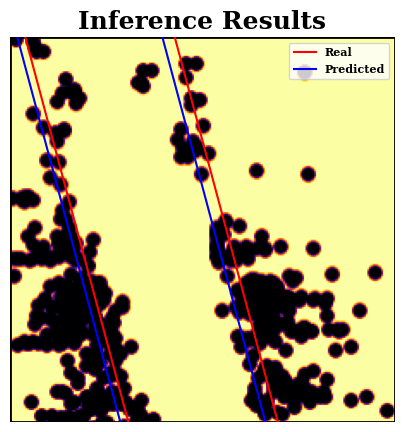

In [134]:
fig, ax = plt.subplots(figsize=(8, 5), frameon=True)

# plot the lines
ax.plot(x, y1, color='red', label='Real')
ax.plot(x, y2, color='red')


ax.plot(x, y1p, color='blue', label='Predicted')
ax.plot(x, y2p, color='blue')

# Customize the title
title_font = {'family': 'serif', 'color': 'black', 'weight': 'bold', 'size': 18}
plt.title('Inference Results', fontdict=title_font)


# Add a white rectangle to create a border
border_style = dict(facecolor='none', edgecolor='black', linewidth=2)
ax.add_patch(plt.Rectangle((0, 0), 1, 1, **border_style, transform=ax.transAxes))

# legend
plt.legend(loc='upper right', prop={'size': 8, 'weight': 'bold', 'family': 'serif'})

# show the image
ax.imshow(image, cmap='inferno')
ax.axis('off')

plt.show()
